# Beijing Air Quality Time Series Forecasting

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os

# Define the path to the data folder
data_folder = 'data'

# List all CSV files in the data folder
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

# Initialize an empty list to store dataframes
dataframes = []

# Loop through the CSV files and read them into dataframes
for file in csv_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Concatenate all dataframes into a single dataframe
all_data = pd.concat(dataframes)

# Create a new column 'date' by parsing year, month, and day columns
all_data['date'] = pd.to_datetime(all_data[['year', 'month', 'day']])

# Display the first few rows of the consolidated all_dataframe
all_data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,date
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,2013-03-01
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,2013-03-01
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,2013-03-01


No             0
year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
date           0
dtype: int64


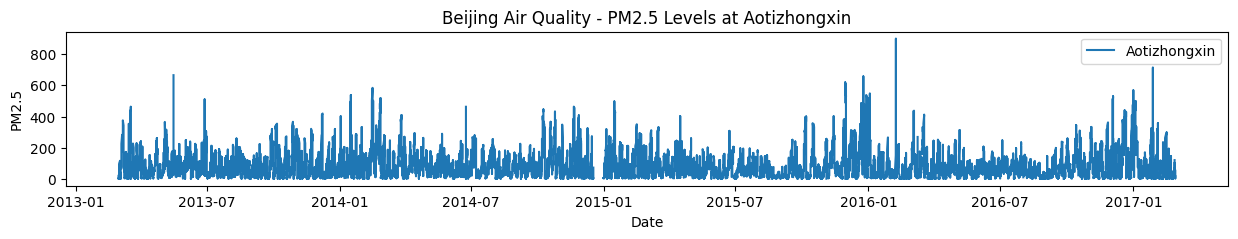

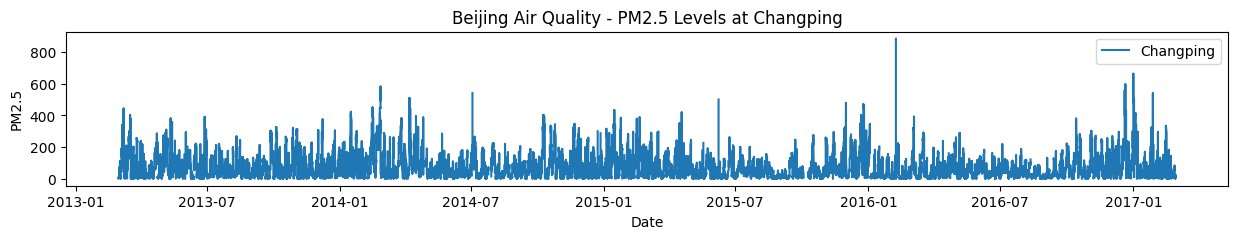

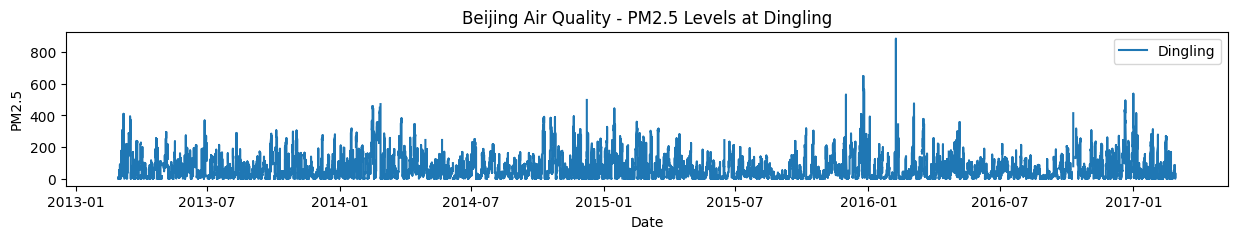

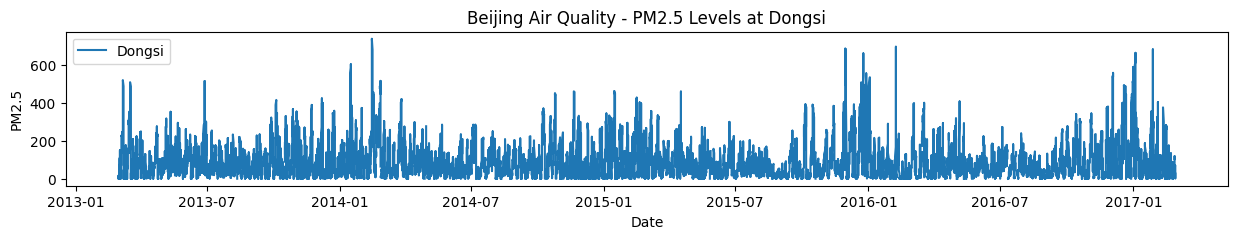

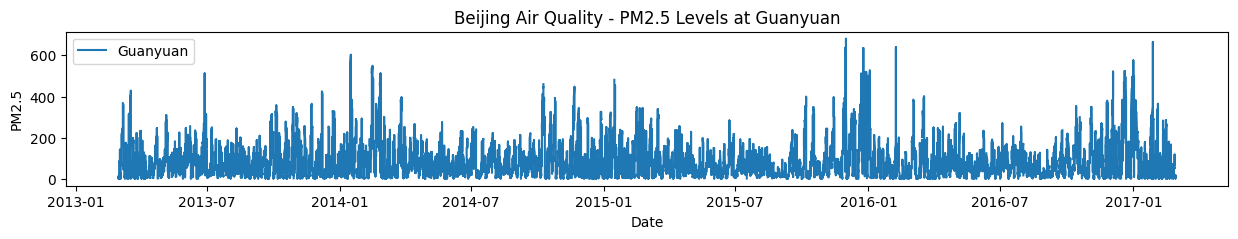

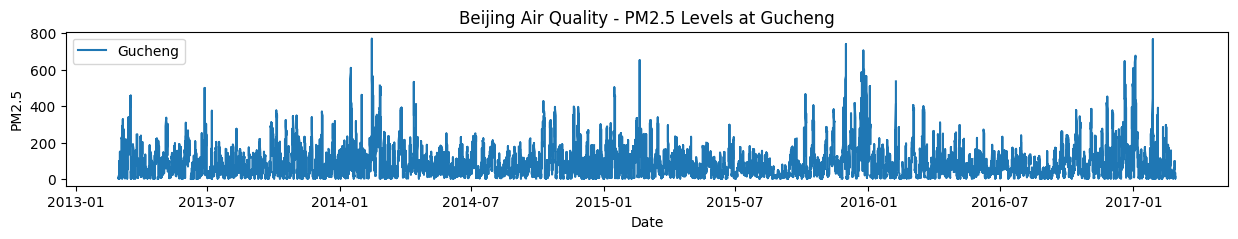

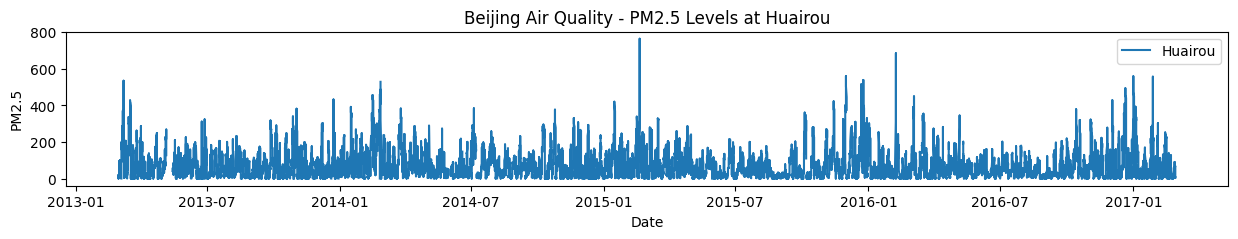

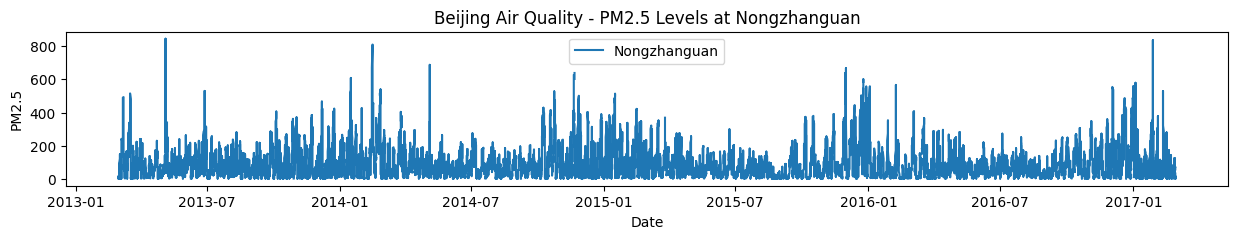

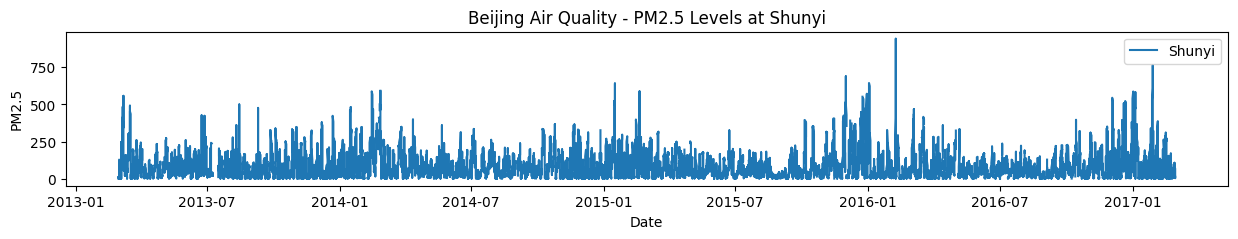

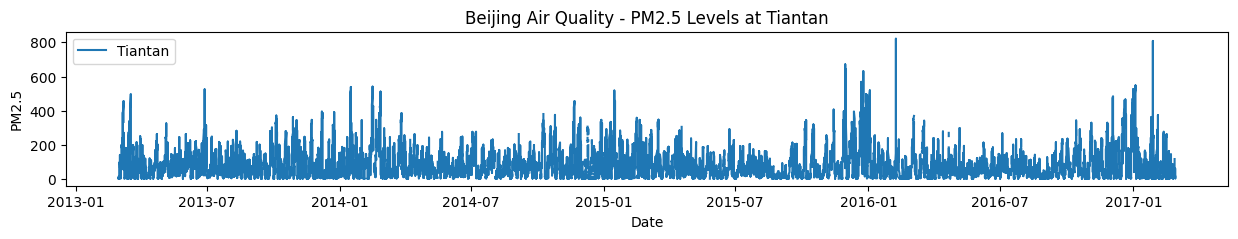

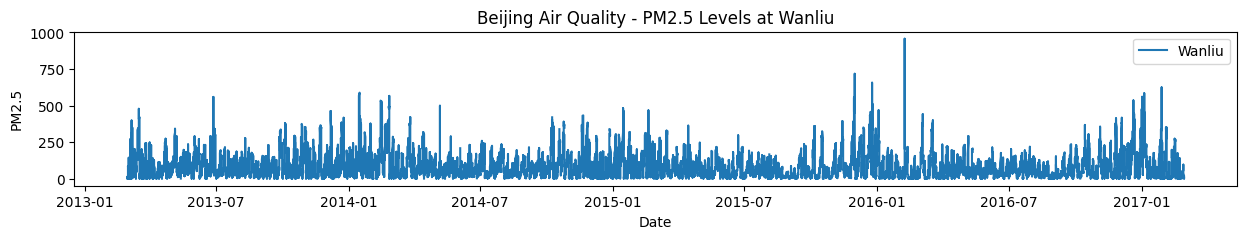

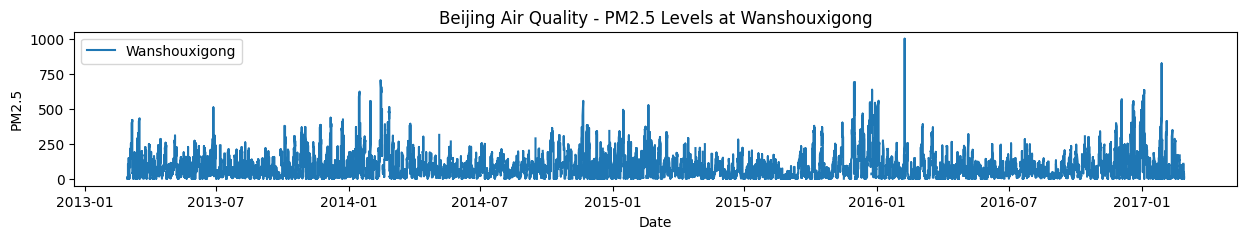

In [3]:
# Data Preprocessing
# Check for missing values
print(all_data.isnull().sum())

# Fill missing values (if any)
# all_data.fillna(method='ffill', inplace=True)

# Visualize the all_data
# Plot all_data for different stations separately
stations = all_data['station'].unique()
for station in stations:
    plt.figure(figsize=(15, 2))
    station_data = all_data[all_data['station'] == station]
    plt.plot(station_data['date'], station_data['PM2.5'], label=station)
    plt.title(f'Beijing Air Quality - PM2.5 Levels at {station}')
    plt.xlabel('Date')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.show()

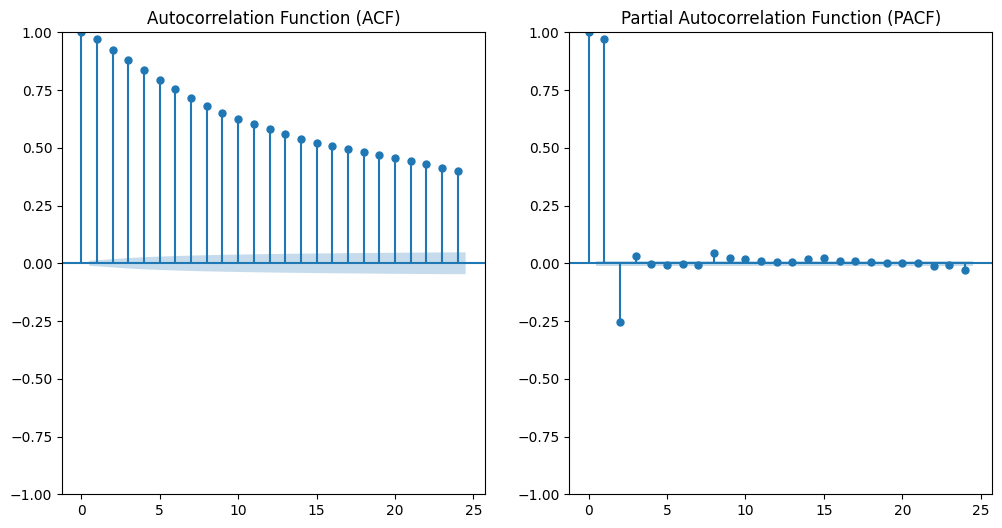

ADF Statistic: -19.06166577426795
p-value: 0.0
Critical Value (1%): -3.431
Critical Value (5%): -2.862
Critical Value (10%): -2.567


In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Filter data to a station
data = all_data[all_data['station'] == 'Dongsi']
lag = 24

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data['PM2.5'].dropna(), lags=lag, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(122)
plot_pacf(data['PM2.5'].dropna(), lags=lag, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(data['PM2.5'].dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

C:\Users\imran.fadhil\AppData\Local\Temp\ipykernel_5048\2061020055.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Forecast'] = arima_forecast


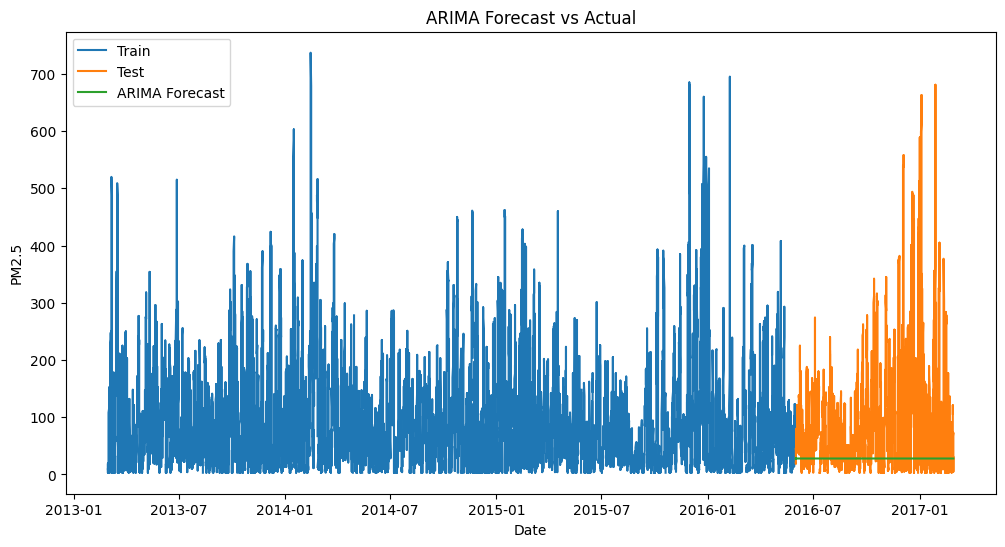

In [5]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA Model
# Split the data into training and testing sets
train = data[data['date'] < '2016-06-01']
test = data[data['date'] >= '2016-06-01']

# Fit the ARIMA model
arima_model = ARIMA(train['PM2.5'], order=(5, 1, 0))
arima_result = arima_model.fit()

# Forecast
arima_forecast = arima_result.forecast(steps=len(test))
test['ARIMA_Forecast'] = arima_forecast

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train.date, train['PM2.5'], label='Train')
plt.plot(test.date, test['PM2.5'], label='Test')
plt.plot(test.date, test['ARIMA_Forecast'], label='ARIMA Forecast')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [43]:
from ipywidgets import widgets, interact

import matplotlib.pyplot as plt

# Define a function to plot the data with a given range
@interact(
        start=widgets.IntSlider(min=0, max=len(data)-100, step=10, value=0),
        window=widgets.IntSlider(min=10, max=len(test), step=50, value=len(test))
)
def plot_data(start, window):
    plt.figure(figsize=(18, 3))
    plt.plot(train.date[start:], train['PM2.5'][start:], label='Train')
    plt.plot(test.date[:window], test['PM2.5'][:window], label='Test')
    plt.scatter(test.date[:window], test['ARIMA_Forecast'][:window], label='ARIMA Forecast', marker='.', c='red')
    plt.xlabel('Date')
    plt.ylabel('PM2.5')
    plt.title('PM2.5 Levels Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


interactive(children=(IntSlider(value=0, description='start', max=34964, step=10), IntSlider(value=6552, descr…

C:\Users\imran.fadhil\AppData\Local\Temp\ipykernel_5048\1469060636.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_exog = train[['TEMP', 'DEWP']].fillna(method='ffill')
C:\Users\imran.fadhil\AppData\Local\Temp\ipykernel_5048\1469060636.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_exog = test[['TEMP', 'DEWP']].fillna(method='ffill')
d:\time_series\Beijing Air Quality\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\imran.fadhil\AppData\Local\Temp\ipykernel_5048\1469060636.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

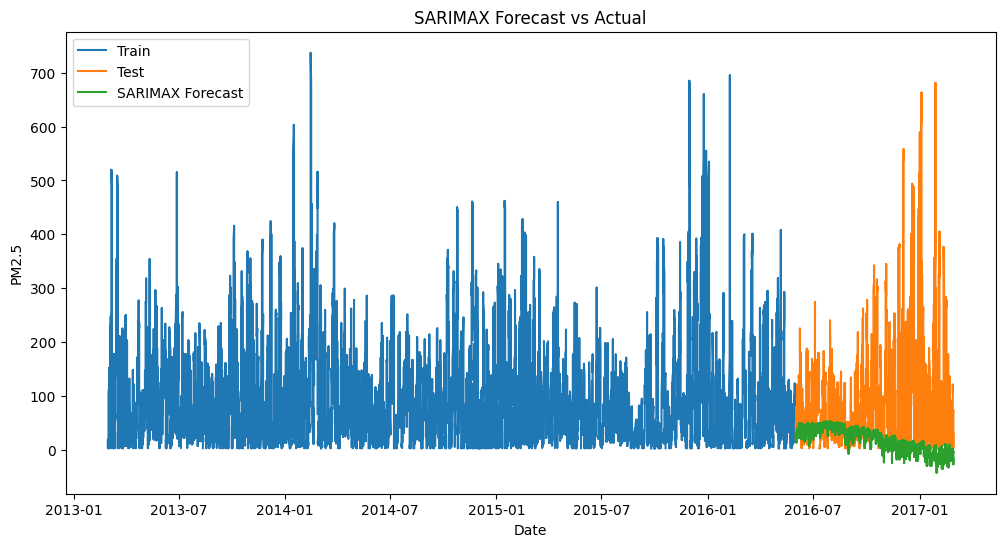

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMAX Model (Multivariate Time Series Analysis)
# Assuming we have additional exogenous variables like temperature and humidity in the dataset

# Split the data into training and testing sets for SARIMAX model
train_exog = train[['TEMP', 'DEWP']].fillna(method='ffill')
test_exog = test[['TEMP', 'DEWP']].fillna(method='ffill')

# Fit the SARIMAX model
sarimax_model = SARIMAX(train['PM2.5'], exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_result = sarimax_model.fit()

# Forecast with SARIMAX model
sarimax_forecast = sarimax_result.forecast(steps=len(test), exog=test_exog)
test['SARIMAX_Forecast'] = sarimax_forecast

# Plot the SARIMAX forecast
plt.figure(figsize=(12, 6))
plt.plot(train.date, train['PM2.5'], label='Train')
plt.plot(test.date, test['PM2.5'], label='Test')
plt.plot(test.date, test['SARIMAX_Forecast'], label='SARIMAX Forecast')
plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [44]:
from ipywidgets import widgets, interact

import matplotlib.pyplot as plt

# Define a function to plot the data with a given range
@interact(
        start=widgets.IntSlider(min=0, max=len(data)-100, step=10, value=0),
        window=widgets.IntSlider(min=10, max=len(test), step=50, value=len(test))
)
def plot_data(start, window):
    plt.figure(figsize=(18, 3))
    plt.plot(train.date[start:], train['PM2.5'][start:], label='Train')
    plt.plot(test.date[:window], test['PM2.5'][:window], label='Test')
    plt.scatter(test.date[:window], test['SARIMAX_Forecast'][:window], label='SARIMAX Forecast', marker='.', c='red')
    plt.xlabel('Date')
    plt.ylabel('PM2.5')
    plt.title('PM2.5 Levels Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


interactive(children=(IntSlider(value=0, description='start', max=34964, step=10), IntSlider(value=6552, descr…

In [8]:
from statsmodels.tsa.stattools import grangercausalitytests

# Perform Granger's causality test
# We will test if TEMP and DEWP can predict PM2.5
max_lag = 12
granger_test_result = grangercausalitytests(data[['PM2.5', 'TEMP', 'DEWP']].dropna(), max_lag)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=105.5087, p=0.0000  , df_denom=34289, df_num=1
ssr based chi2 test:   chi2=105.5210, p=0.0000  , df=1
likelihood ratio test: chi2=105.3590, p=0.0000  , df=1


ValueError: wrong shape for coefs

In [ ]:
from statsmodels.tsa.api import VAR

# Prepare the data for VAR model
# We will use PM2.5, TEMP, and DEWP as variables
var_data = data[['date', 'PM2.5', 'TEMP', 'DEWP']].dropna()
var_data.set_index('date', inplace=True, drop=True)

# Split the data into training and testing sets
train_var = var_data[var_data.index < '2016-06-01']
test_var = var_data[var_data.index >= '2016-06-01']

# Fit the VAR model
var_model = VAR(train_var)
var_result = var_model.fit(maxlags=15, ic='aic')

# Forecast
lag_order = var_result.k_ar
var_forecast_input = train_var.values[-lag_order:]
var_forecast = var_result.forecast(y=var_forecast_input, steps=len(test_var))

# Convert forecast to DataFrame
var_forecast_df = pd.DataFrame(var_forecast, index=test_var.index, columns=train_var.columns)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_var['PM2.5'], label='Train')
plt.plot(test_var['PM2.5'], label='Test')
plt.plot(var_forecast_df['PM2.5'], label='VAR Forecast')
plt.title('VAR Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

d:\time_series\Beijing Air Quality\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ValueError: shapes (3,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)

In [45]:
from ipywidgets import widgets, interact

import matplotlib.pyplot as plt

# Define a function to plot the data with a given range
@interact(
        start=widgets.IntSlider(min=0, max=len(data)-100, step=10, value=0),
        window=widgets.IntSlider(min=10, max=len(test), step=50, value=len(test))
)
def plot_data(start, window):
    plt.figure(figsize=(18, 3))
    plt.plot(train_var.index[start:], train_var['PM2.5'][start:], label='Train')
    plt.plot(test_var.index[:window], test_var['PM2.5'][:window], label='Test')
    plt.scatter(test_var.index[:window], var_forecast_df['PM2.5'][:window], label='VAR Forecast', marker='.', c='red')
    plt.ylabel('PM2.5')
    plt.title('PM2.5 Levels Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


interactive(children=(IntSlider(value=0, description='start', max=34964, step=10), IntSlider(value=6552, descr…

17:50:38 - cmdstanpy - INFO - Chain [1] start processing
17:50:45 - cmdstanpy - INFO - Chain [1] done processing


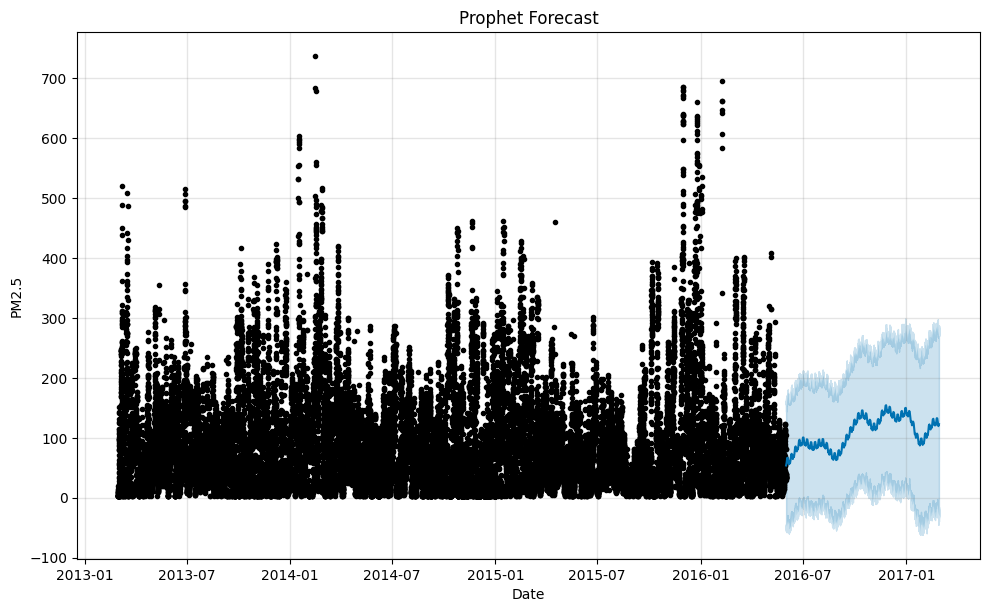

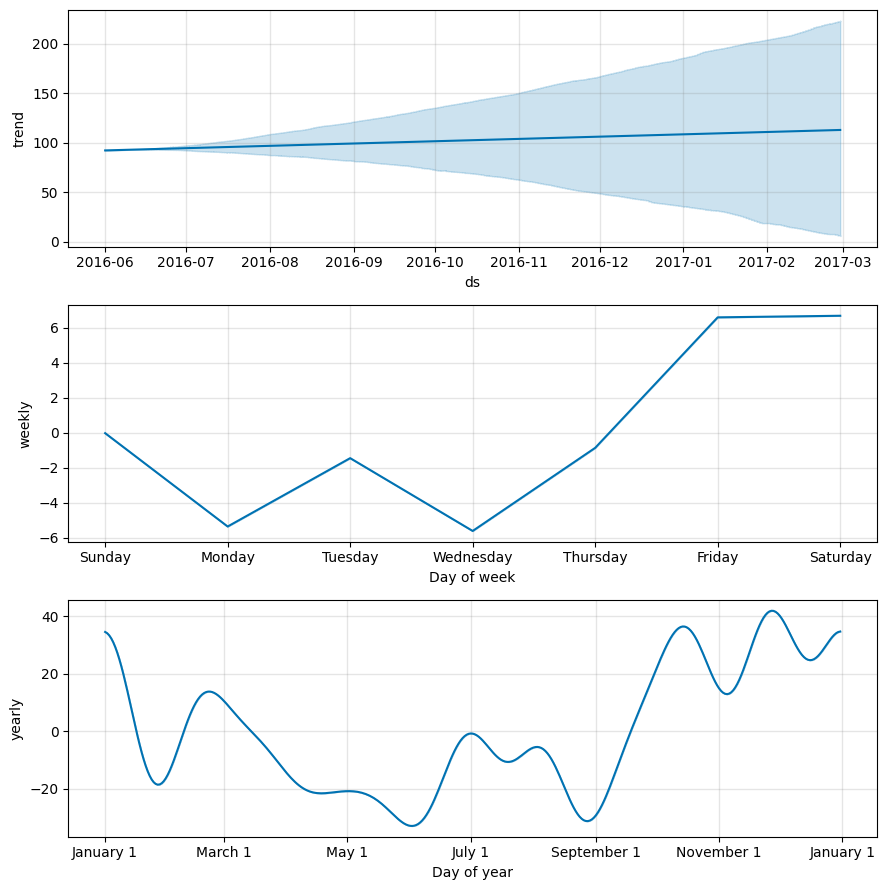

In [33]:
from prophet import Prophet

# Prophet Model
# Prepare the data for Prophet
prophet_data = train.reset_index().rename(columns={'date': 'ds', 'PM2.5': 'y'})

# Fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Make future dataframe
# future = prophet_model.make_future_dataframe(periods=365)
forecast = prophet_model.predict(test.reset_index().rename(columns={'date': 'ds'}))

# Plot the forecast
fig = prophet_model.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.show()

# Display the forecast components
fig2 = prophet_model.plot_components(forecast)
plt.show()